<a href="https://colab.research.google.com/github/Eshan133/Caltech101_resnet50/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

----
# 1. Getting the dataset ready

In [ ]:
from torchvision.transforms import Grayscale, ToTensor, Compose, Resize, Pad

# Define a transformation
transform = transforms.Compose([
    Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
    transforms.Resize((300,300)),  # Resize the shorter side to 300
    transforms.Pad((10, 10, 10, 10), fill=0),  # Add padding if needed
    transforms.ToTensor()
])

In [ ]:
data = datasets.Caltech101(
    root='data',
    # train =True,
    download=True,
    transform=transform,
    target_transform=None
)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=d26ca326-ceda-4493-a63f-8d9bd333415c
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 100MB/s]


Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=62ad1e5f-1a90-4684-9bf1-59610b9e97b9
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 48.0MB/s]


Extracting data/caltech101/Annotations.tar to data/caltech101


## 1.1 Checking the input and output shapes of data

In [ ]:
len(data)

8677

In [ ]:
image, label = data[200]

In [ ]:
class_names = data.annotation_categories
len(class_names)

101

In [ ]:
image.shape

torch.Size([3, 320, 320])

In [ ]:
print(f"Image shape: {image.shape} ->> [color_channels, height, width]")
print("Only 1 as color_channel represents that the image is black and white")
print("----------------------------------------------------")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([3, 320, 320]) ->> [color_channels, height, width]
Only 1 as color_channel represents that the image is black and white
----------------------------------------------------
Image label: Faces_2


## 1.2 Checking Image Dimension and Color Channel

In [ ]:
height = []
width = []
color_channels = []

for image, _ in data:
    c, h, w = image.shape
    height.append(h)
    width.append(w)
    color_channels.append(c)



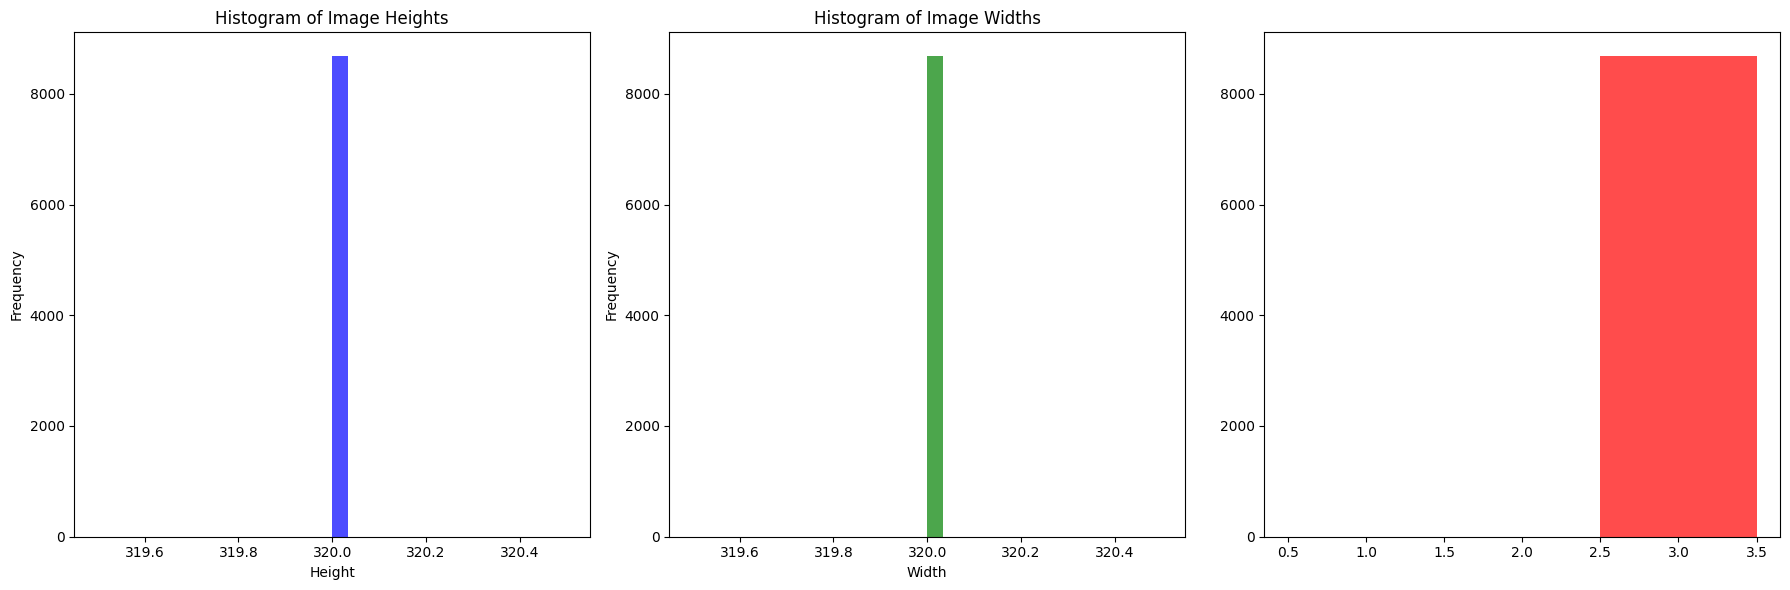

In [ ]:
height = np.array(height)
width = np.array(width)
color_channels = np.array(color_channels)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Histogram for height
axs[0].hist(height, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Image Heights')
axs[0].set_xlabel('Height')
axs[0].set_ylabel('Frequency')

# # Histogram for width
axs[1].hist(width, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram of Image Widths')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Frequency')

# # Histogram for color channels
axs[2].hist(color_channels, bins=[0.5, 1.5, 2.5, 3.5], color='red', alpha=0.7)


plt.tight_layout()
plt.show()

In [ ]:
max(color_channels)

3

## 1.3 Data Visualization

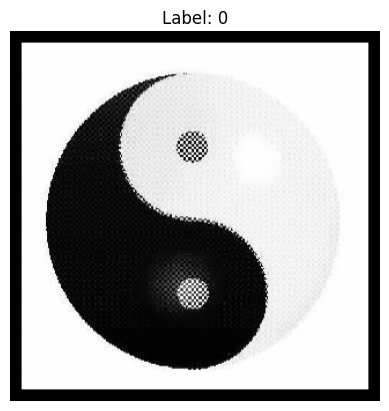

In [ ]:
# Convert tensor to numpy array (for visualization)
image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide axes
plt.show()

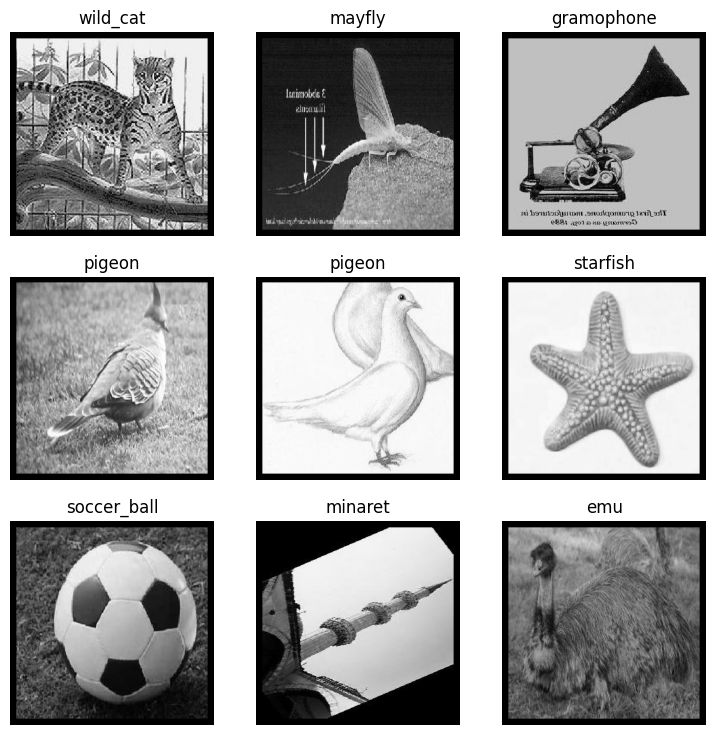

In [ ]:
fig = plt.figure(figsize=(9,9))
rows = 3
cols = 3

for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(data), size=[1]).item()
  img, label = data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.title(class_names[label])
  plt.axis(False)

---
## 1.4 Train Test split

In [ ]:
from torch.utils.data import random_split

# Defining the train and test size
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

print(f"Total size of the dataset: {len(data)}")
print(f"Size of the Train Dataset: {train_size}")
print(f"Size of the Test Dataset: {test_size}")

Total size of the dataset: 8677
Size of the Train Dataset: 7809
Size of the Test Dataset: 868


In [ ]:
# Random split of data into train and test
train_data, test_data = random_split(data,[train_size,test_size])

In [ ]:
len(train_data), len(test_data)

(7809, 868)

-----
# 2. Preparing **DataLoader**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## 2.1 Visualizing **DataLoader**

In [ ]:
print(f'Train DataLoader: {train_dataloader}')
print(f'Test DataLoader: {test_dataloader}')
print('-----------------------------------------------------------------------')
print(f"Length of train data: {len(train_data)}")
print(f"Length of test data: {len(test_data)}")
print('-----------------------------------------------------------------------')
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}.....")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}.....")

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7b481b267210>
Test DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7b481b26cf50>
-----------------------------------------------------------------------
Length of train data: 7809
Length of test data: 868
-----------------------------------------------------------------------
Length of train_dataloader: 245 batches of 32.....
Length of test_dataloader: 28 batches of 32.....


## 2.2 Extracting data from the **DataLoader**

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

In [ ]:
print(f"Shape of train features in single iteration: {train_features.shape}")
print(f"Shape of train labels in single iteration: {train_labels.shape}")

Shape of train features in single iteration: torch.Size([32, 3, 320, 320])
Shape of train labels in single iteration: torch.Size([32])


Shape of Random Image: 
torch.Size([3, 320, 320])

Shape of Random Image after Transformation: 
(320, 320, 3)



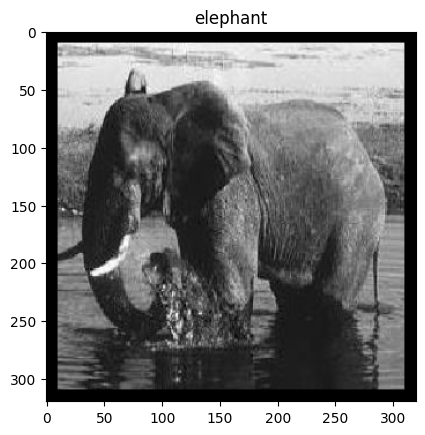

In [ ]:
rand_idx = torch.randint(0, len(train_features), size=[1]).item()
img = train_features[rand_idx]
label = train_labels[rand_idx]

print(f"Shape of Random Image: \n{img.shape}\n")

img = img.permute(1, 2, 0).numpy()
print(f"Shape of Random Image after Transformation: \n{img.shape}\n")

plt.imshow(img)
plt.title(class_names[label])
plt.show()

---
# 3. Functionizing the training || testing loop || Evaluation || Prediction


## 3.1 Training Loop

In [ ]:
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  model.train()
  model.to(device)
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forwared Pass
    y_pred = model(X)

    # Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Accuracy
    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_acc += acc

    # Optimizer zero
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    if(batch % 100 == 0):
      print(f"{batch} batches completed.. ")

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.5f} || Train Accuracy: {train_acc:.2f}%")

## 3.2 Testing Loop

In [ ]:
def test_loop(model,
              dataloader,
              loss_fn,
              accuracy_fn,
              device):

  model.eval()
  model.to(device)

  with torch.inference_mode():
    test_acc, test_loss = 0, 0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test Loss: {test_loss:.5f} || Train Accuracy: {test_acc:.2f}%")


## 3.3 Evaluation function

In [ ]:
def evaluation(model:torch.nn.Module,
               dataloader:torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device = device):
  model.eval()

  model.to(device)
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return {
      'model_name': model.__class__.__name__,
      'model_loss': test_loss.item(),
      'model_accuracy':test_acc
  }

## 3.4 Prediction Function

In [ ]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device=device):

  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

----

# 4. Building and training the model

## **4.1 ModelV1**

In [ ]:
class ModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_shape:int,
               output_shape:int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )

    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_shape * 318 * 318,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifer(x)
    # print(x.shape)

    return x


In [ ]:
modelV1 = ModelV1(input_shape=3,
                  hidden_shape=10,
                  output_shape=len(class_names)).to(device)

In [ ]:
modelV1

ModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1011240, out_features=101, bias=True)
  )
)

In [ ]:
train_dataloader.dataset

In [ ]:
## Trying with a random data
demo_data = torch.randn(1, 3, 320, 320).to(device)

In [ ]:
y_pred_demo = modelV1(demo_data)
# Using data from this i.e.80758 for the classifier

### 4.1.1 Defining the Loss, Optimizer, and Accuracy

In [ ]:
import requests
from pathlib import Path

if(Path("helper_functions.py").is_file()):
  print("helper_functions.py already exists")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/Eshan133/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
    print("Download complete")

helper_functions.py already exists


In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.1)

### 4.1.2 Define Timer function

In [ ]:
from timeit import default_timer as timer

def print_time(start:float, end:float, device:torch.device=None):
  total_time = end - start
  print(f"Total time taken on {device}: {total_time:.3f} seconds")
  return total_time

### 4.1.3 Traning the model

In [ ]:
from tqdm.auto import tqdm

epochs = 3
start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_loop(model= modelV1,
             dataloader= train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

  test_loop(model= modelV1,
             dataloader= train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

end_time = timer()
modelV1_time = print_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: nan || Train Accuracy: 5.33%
Test Loss: nan || Train Accuracy: 4.91%
Epoch: 1
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: nan || Train Accuracy: 4.91%
Test Loss: nan || Train Accuracy: 4.91%
Epoch: 2
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: nan || Train Accuracy: 4.91%
Test Loss: nan || Train Accuracy: 4.91%
Total time taken on cuda: 248.939 seconds


In [ ]:
eval_modelV1 = evaluation(model=modelV1,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)

In [ ]:
eval_modelV1

{'model_name': 'ModelV1',
 'model_loss': nan,
 'model_accuracy': 5.580357142857143}

---

## 4.2 Transfer Learning: **ResNet-50**

### 4.2.1 Defining the model

In [ ]:
# Loading pre-trained model

import torchvision.models as models
import torch.nn as nn

model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)  # Adjust output layer to 101 classes


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


### 4.2.2 Defining the Loss, Optimizer & Unfreezing last few layers

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)  # Only fine-tuning last layer

# Optionally fine-tune deeper layers
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True  # Unfreeze last layer4 for better adaptation


### 4.2.3 Training the model

In [ ]:
from tqdm.auto import tqdm

epochs = 5

start_time = timer()
for epoch in tqdm(range(epochs)):
  print(f"EPOCH: {epoch}")
  train_loop(model=model,
             dataloader=train_dataloader,
             loss_fn=criterion,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

  test_loop(model=model,
             dataloader=train_dataloader,
             loss_fn=criterion,
             accuracy_fn=accuracy_fn,
             device=device)

end_time = timer()
modelV2_time = print_time(start_time, end_time, device)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: 4.56642 || Train Accuracy: 59.29%
Test Loss: 1.44359 || Train Accuracy: 79.96%
EPOCH: 1
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: 1.87541 || Train Accuracy: 76.48%
Test Loss: 1.21290 || Train Accuracy: 81.80%
EPOCH: 2
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: 1.54990 || Train Accuracy: 81.36%
Test Loss: 2.15784 || Train Accuracy: 75.83%
EPOCH: 3
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: 1.61221 || Train Accuracy: 82.97%
Test Loss: 1.03037 || Train Accuracy: 87.74%
EPOCH: 4
0 batches completed.. 
100 batches completed.. 
200 batches completed.. 
Train Loss: 1.70431 || Train Accuracy: 85.17%
Test Loss: 1.36300 || Train Accuracy: 85.31%
Total time taken on cuda: 1154.050 seconds


In [ ]:
eval_modelV2 = evaluation(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)

---
## 5. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([
    eval_modelV1,
    eval_modelV2
])

In [ ]:
# Adding Training time to results pd
compare_results["Training Time"] = [modelV1_time,
                                    modelV2_time]

In [ ]:
compare_results

,model_name,model_loss,model_accuracy,Training Time
0,ModelV1,NaN,5.580357,248.939120
1,ResNet,2.125679,81.250000,1154.049832


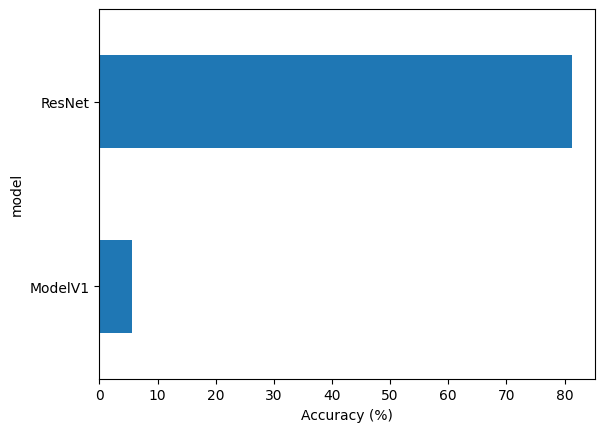

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_accuracy"].plot(kind='barh')
plt.xlabel("Accuracy (%)")
plt.ylabel("model");

## 6. Making Prediction

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [ ]:
pred_probs = make_predictions(model=model,
                              data=test_samples)

# Convert pred probabilities to labels
pred_class = pred_probs.argmax(dim=1)

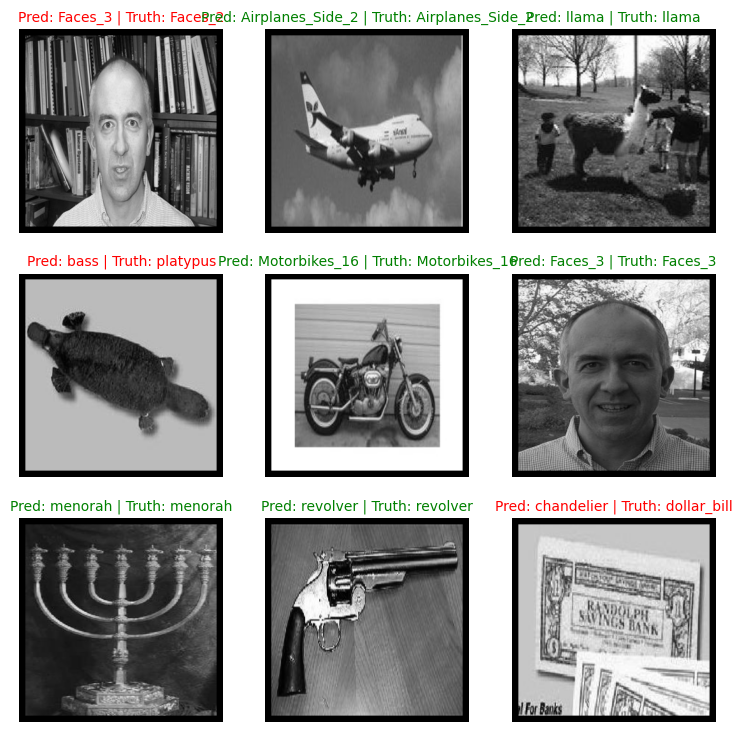

In [ ]:
plt.figure(figsize=(9,9))
nrow = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrow, ncols, i+1)

  plt.imshow(sample.permute(1,2,0).numpy(), cmap="grey")

  pred_label = class_names[pred_class[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);